#  Evolutionary Multiple-objective Optimization (part for 4.0)
- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA-II/NSGA-III/MOEA/D; except for NSGA).
- Note that it has to be your implementation (using external libraries is forbidden; EXCEPTION: you can use the JECDM framework: https://jecdm.cs.put.poznan.pl -- but it is a relatively complex software, and much effort must be spent to understand how to use it).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, tackle also a three-objective one. As for the third objective, think about some reasonable risk-measure. E.g., you can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

NUM_ASSETS = 20

# Function to read asset data from a text file
def read_asset_data(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

        asset_name = lines[0].strip()
        num_points = int(lines[1].strip())
        data = [float(line.split()[1]) for line in lines[2 : num_points + 2]]

    return asset_name, data


# Read all asset data
asset_data = {}
for file in sorted(pathlib.Path("data").glob("*Part1.txt")):
    asset_name, data = read_asset_data(file)
    asset_data[asset_name] = data
asset_data = pd.DataFrame(asset_data)

assert len(asset_data.columns) == NUM_ASSETS

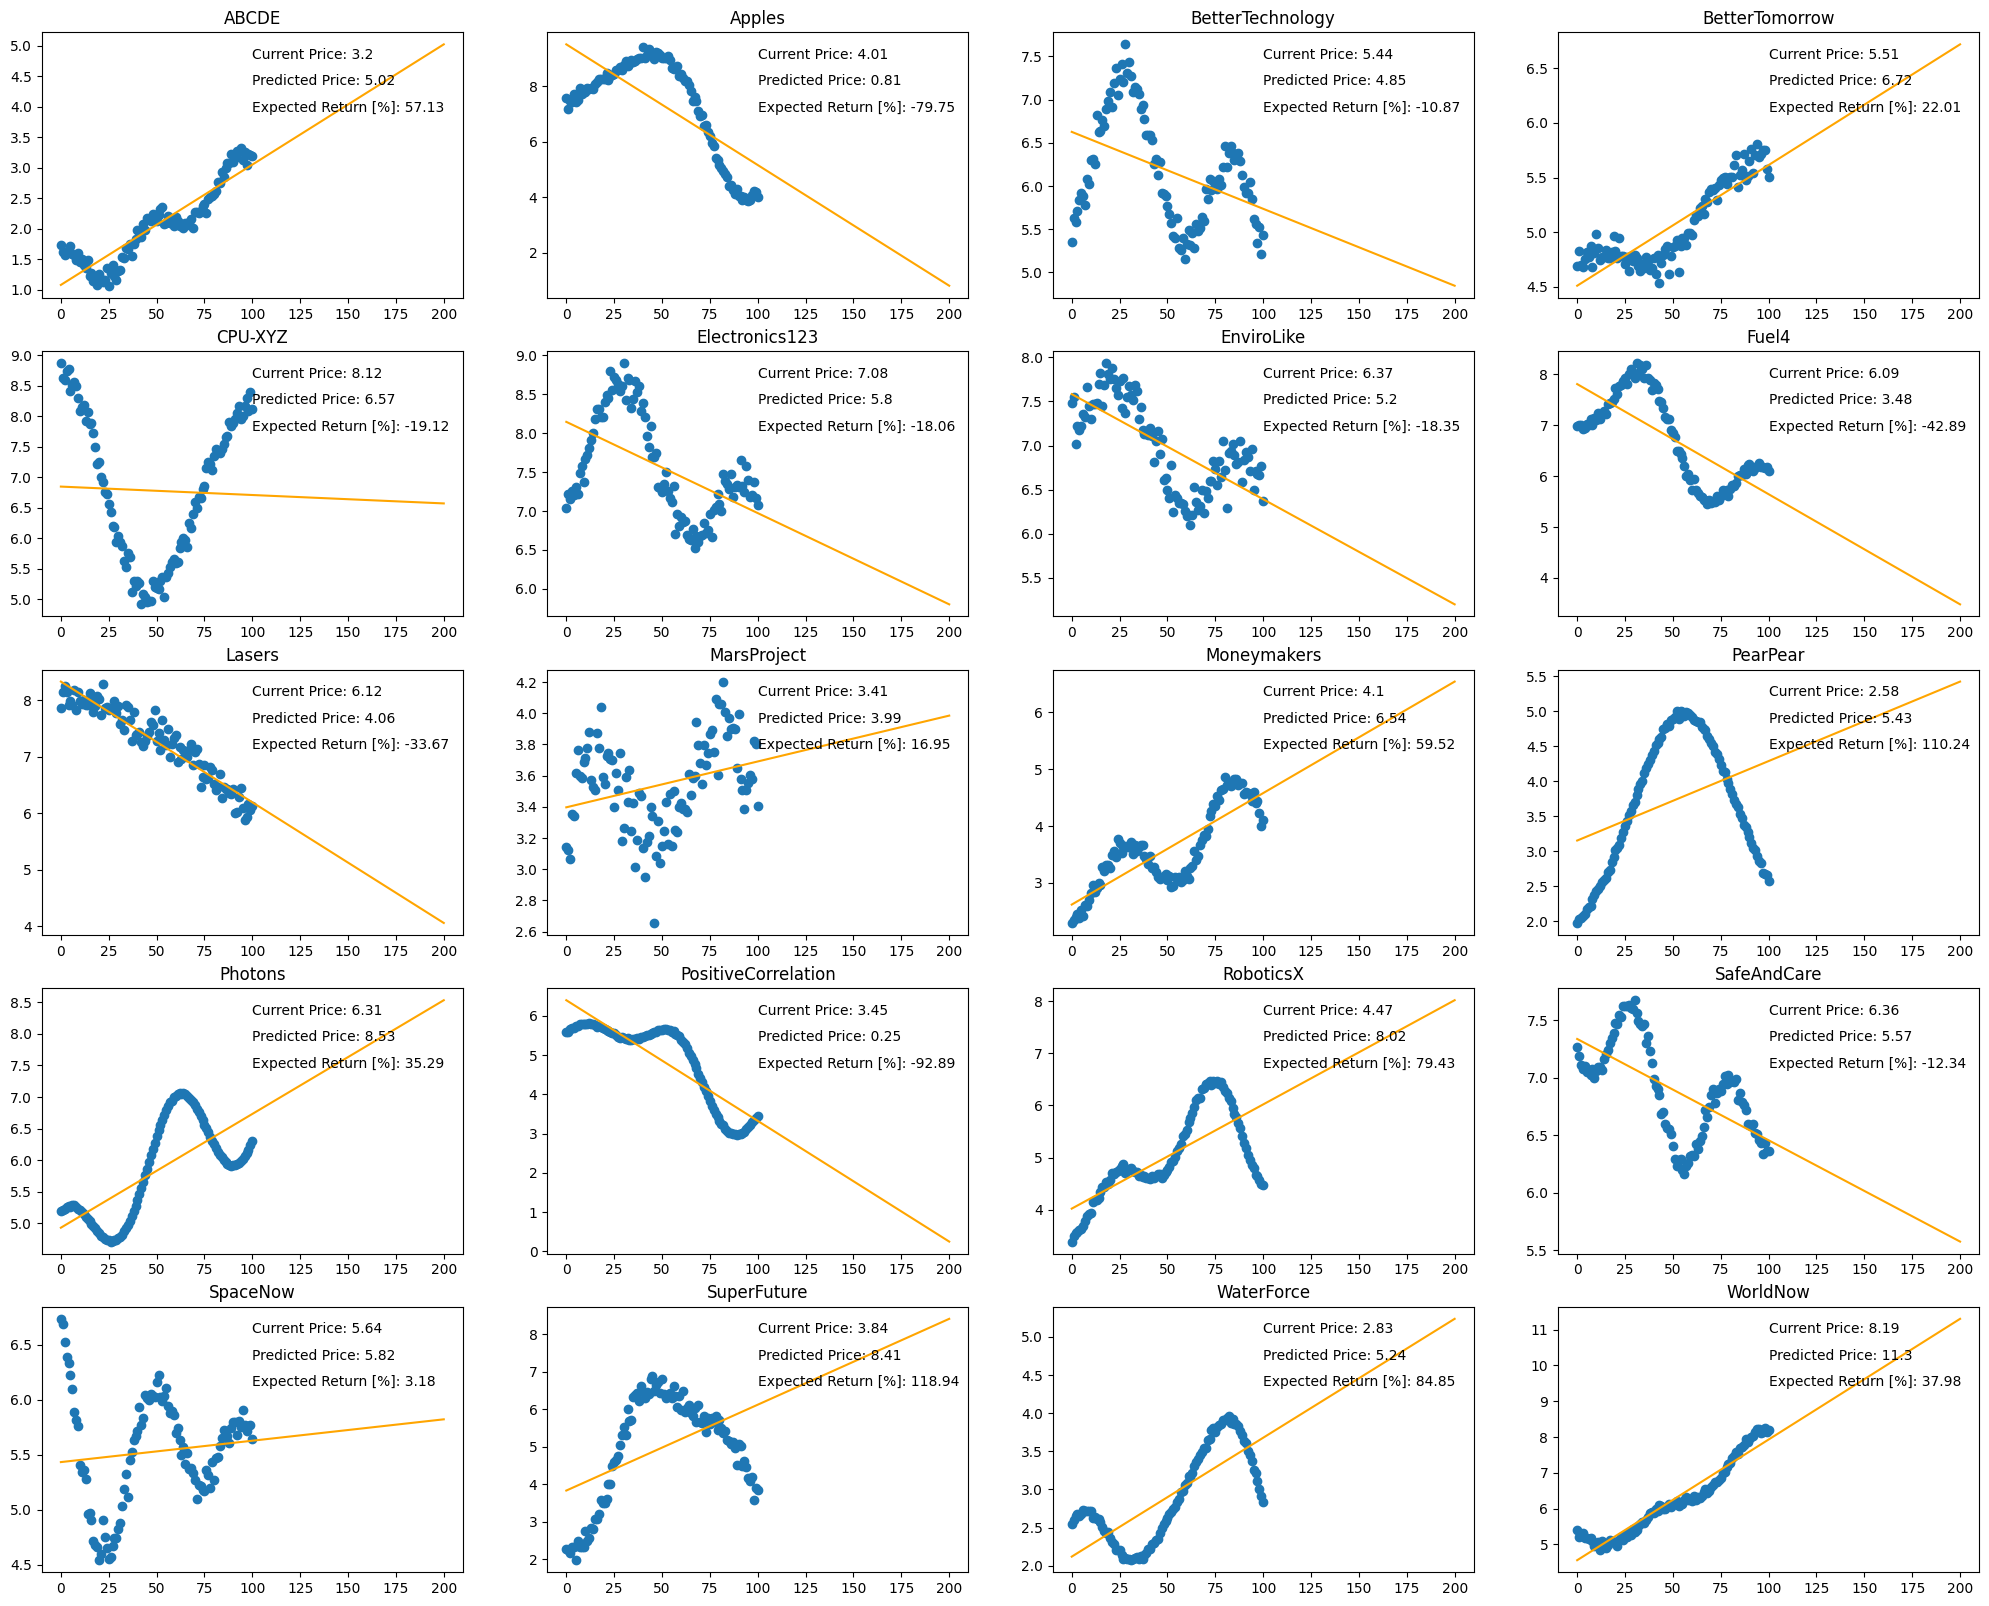

In [12]:
fig, axs = plt.subplots(5, 4, figsize=(25, 20))
predicted_returns = np.zeros(NUM_ASSETS)
for i, asset in enumerate(asset_data.columns):
    ax = axs.flat[i]
    ax.set_title(asset)

    data = asset_data[asset].values
    model = LinearRegression()
    model.fit(np.arange(0, 101).reshape(-1, 1), data)

    # stock_mean, stock_std = np.mean(data), np.std(data)
    predictions = model.predict(np.arange(0, 201).reshape(-1, 1))

    ax.scatter(np.arange(0, 101), asset_data[asset])
    ax.plot(np.arange(0, 201), predictions, color="orange")

    cur = data[100]
    pred = predictions[200]
    ret = (pred - cur) / cur * 100
    # print(i)
    predicted_returns[i] = ret
    ax.text(0.5, 0.9, f"Current Price: {np.round(cur, 2)}", transform=ax.transAxes)
    ax.text(0.5, 0.8, f"Predicted Price: {np.round(pred, 2)}", transform=ax.transAxes)
    ax.text(
        0.5, 0.7, f"Expected Return [%]: {np.round(ret, 2)}", transform=ax.transAxes
    )

In [22]:
MU = predicted_returns
SIGMA = asset_data.cov().values

np.savetxt('predicted_returns.csv', np.round(MU, 5), delimiter=',')
np.savetxt('cov_matrix.csv', np.round(SIGMA, 5), delimiter=',')

In [74]:
! ./a.out

In [ ]:
random_profit_risk = pd.read_csv('output.csv',header=None)
random_profit = list(random_profit_risk[0])
random_risk = list(random_profit_risk[1])
random_nonzero = list(random_profit_risk[2])

solutions = np.identity(NUM_ASSETS)
risks= []
profits=[]
non_zeros = []
for sol in solutions:
    profit=0
    risk=0
    non_zero = 0
    for i in range(NUM_ASSETS):
        profit += sol[i] * MU[i]
        for j in range(NUM_ASSETS):
            risk += sol[i] * sol[j] * SIGMA[i][j]
    for i in range(NUM_ASSETS):
        if sol[i] >= 0.01:
            non_zero += 1
    profits.append(profit)
    risks.append(risk)
    non_zeros.append(non_zero)
random_profit.extend(profits)
random_risk.extend(risks)
random_nonzero.extend(non_zeros)

# filter data points that are too big with covarianc


In [112]:
import random

def random_portfolio():
    weights = [random.random() for _ in range(NUM_ASSETS)]
    s = sum(weights)
    weights = [w / s for w in weights]
    return weights

def portfolio_return(weights):
    return sum(w * m for w, m in zip(weights, MU))

def portfolio_variance(weights):
    var = 0.0
    for i in range(NUM_ASSETS):
        for j in range(NUM_ASSETS):
            var += weights[i] * weights[j] * SIGMA[i][j]
    return var

def evaluate2(weights):
    var = portfolio_variance(weights)
    ret = portfolio_return(weights)
    return (var, -ret)

def count_non_zero(weights, eps=0.01):
    """Count how many weights are non-trivially > 0.
    We use a small epsilon to allow for floating-point noise"""
    return sum(1 for w in weights if w > eps)

def evaluate3(weights):
    var = portfolio_variance(weights)
    ret = portfolio_return(weights)
    non_zero = count_non_zero(weights)
    return (var, -ret, -non_zero)

def dominates(obj1, obj2):
    """
    Check if obj1 = (o1_1, o1_2, ...) dominates obj2 = (o2_1, o2_2, ...).
    We say obj1 dominates obj2 if:
      - obj1 is <= obj2 in all objectives (since we consider all minimization)
      - obj1 is <  obj2 in at least one objective
    """
    for o1, o2 in zip(obj1, obj2):
        if o1 > o2:
            return False

    for o1, o2 in zip(obj1, obj2):
        if o1 < o2:
            return True

    return False

def fast_non_dominated_sort(pop):
    """
    Perform the fast non-dominated sort on the population.
    pop is a list of tuples: (weights, (obj1, obj2), ...)
    Return a list of fronts, where each front is a list of indices of pop.
    """
    size = len(pop)
    S = [[] for _ in range(size)]  # S[i] will hold the solutions that i dominates
    n = [0]*size                   # n[i] will hold the number of solutions that dominate i
    rank = [0]*size

    for p in range(size):
        p_objs = pop[p][1]
        for q in range(size):
            if p == q: 
                continue
            q_objs = pop[q][1]
            if dominates(p_objs, q_objs):
                S[p].append(q)
            elif dominates(q_objs, p_objs):
                n[p] += 1

    # Identify the first front
    fronts = [[]]
    for i in range(size):
        if n[i] == 0:
            rank[i] = 0
            fronts[0].append(i)
    
    # Build subsequent fronts
    i = 0
    while i < len(fronts) and fronts[i]:
        next_front = []
        for p in fronts[i]:
            # for each q dominated by p
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        if next_front:
            fronts.append(next_front)
    return fronts

def crowding_distance_assignment(pop, front):
    """
    Assign crowding distance for each solution in a given front.
    pop is a list of (weights, objective_tuple)
    front is a list of indices into pop.
    We'll return a dictionary: index -> crowding distance.
    """
    distance = {i: 0.0 for i in front}
    if not front:
        return distance
    
    num_objectives = len(pop[front[0]][1])
    
    for m in range(num_objectives):
        front_sorted = sorted(front, key=lambda i: pop[i][1][m])
        distance[front_sorted[0]] = float('inf')
        distance[front_sorted[-1]] = float('inf')
        
        f_min = pop[front_sorted[0]][1][m]
        f_max = pop[front_sorted[-1]][1][m]
        if f_max == f_min:
            continue

        for idx in range(1, len(front_sorted)-1):
            prev_i = front_sorted[idx-1]
            next_i = front_sorted[idx+1]
            dist = (pop[next_i][1][m] - pop[prev_i][1][m]) / (f_max - f_min)
            distance[front_sorted[idx]] += dist

    return distance


def make_new_population(pop, pop_size):
    """
    Given the combined population (parents + offspring),
    perform the NSGA-II selection of the next generation.
    pop is a list of (weights, objective_tuple).
    We return a new list of pop_size individuals.
    """
    fronts = fast_non_dominated_sort(pop)
    
    new_pop = []
    for front in fronts:
        if len(new_pop) + len(front) <= pop_size:
            new_pop.extend(front)
        else:
            distances = crowding_distance_assignment(pop, front)
            sorted_front = sorted(front, key=lambda i: distances[i], reverse=True)
            needed = pop_size - len(new_pop)
            new_pop.extend(sorted_front[:needed])
            break
    
    return [pop[i] for i in new_pop]


def tournament_selection(pop, k=2):
    """
    Perform a tournament selection of size k and return the winner.
    We pick k individuals randomly from pop.
    The winner is the one with:
      1) Lower rank, or
      2) Higher crowding distance if the same rank
    But to do that, we need the rank and crowding info, so let's do:
      - We first do a full non-dominated sort and store rank.
      - Then we do a crowding distance assignment for each front.
    """
    fronts = fast_non_dominated_sort(pop)
    rank_of = {}
    for i, front in enumerate(fronts):
        for idx in front:
            rank_of[idx] = i
    
    distance_of = {}
    for front in fronts:
        dist = crowding_distance_assignment(pop, front)
        distance_of.update(dist)
    
    contenders = random.sample(range(len(pop)), k)
    best = contenders[0]
    for c in contenders[1:]:
        if rank_of[c] < rank_of[best]:
            best = c
        elif rank_of[c] == rank_of[best]:
            if distance_of[c] > distance_of[best]:
                best = c
    return pop[best]

def crossover(w1, w2, crossover_rate=0.9):
    """
    Single-point crossover for simplicity.
    With 'crossover_rate' probability, do crossover,
    otherwise return copies of the original.
    """
    if random.random() < crossover_rate:
        point = random.randint(1, NUM_ASSETS - 1)
        child1 = w1[:point] + w2[point:]
        child2 = w2[:point] + w1[point:]
        return child1, child2
    else:
        return w1[:], w2[:]

def mutate(weights, mutation_rate=0.1):
    """
    Mutate each weight with probability = mutation_rate,
    then re-normalize so sum of weights = 1.
    """
    for i in range(NUM_ASSETS):
        if random.random() < mutation_rate:
            weights[i] *= random.uniform(0.3, 2.5)
            if weights[i] < 0:
                weights[i] = 0
    s = sum(weights)
    if s == 0:
        return random_portfolio()
    return [w/s for w in weights]


def nsga2_markowitz(pop_size, generations, evaluate=evaluate2):
    population = [random_portfolio() for _ in range(pop_size)]
    pop_evaluated = [(ind, evaluate(ind)) for ind in population]
    for gen in range(generations):
        offspring = []
        while len(offspring) < pop_size:
            p1 = tournament_selection(pop_evaluated)
            p2 = tournament_selection(pop_evaluated)
            
            c1_weights, c2_weights = crossover(p1[0], p2[0])
            
            c1_weights = mutate(c1_weights)
            c2_weights = mutate(c2_weights)
            
            c1_fit = evaluate(c1_weights)
            c2_fit = evaluate(c2_weights)
            
            offspring.append((c1_weights, c1_fit))
            offspring.append((c2_weights, c2_fit))
        
        combined = pop_evaluated + offspring
        pop_evaluated = make_new_population(combined, pop_size)
    
    return pop_evaluated


final_pop = nsga2_markowitz(pop_size=50, generations=100, evaluate=evaluate2)

fronts = fast_non_dominated_sort(final_pop)

Number of solutions in first Pareto front: 50
Approximate Pareto front (variance, return):
Variance = 0.884545, Return = 110.2278 Non-zero: 1, Weights = [3.023686704905403e-05, 8.308629962836698e-07, 1.747905076252271e-07, 4.266538174782944e-06, 8.653835809821859e-06, 3.7158523414649424e-06, 3.890037415691216e-06, 4.414472239203307e-06, 2.4558576379721317e-07, 1.860828466790055e-06, 6.535032489445057e-06, 0.9997355156002091, 1.091236843543806e-06, 1.759248324228793e-06, 1.920644434880668e-06, 1.4699299450219043e-06, 2.8544061463164446e-05, 1.7218428095418872e-05, 0.0001461162950806749, 1.5398523500011065e-06]
Variance = 0.001793, Return =   7.6763 Non-zero: 19, Weights = [0.024003293430371105, 0.008434148653798532, 0.019044694831612734, 0.06219427694501198, 0.07049613021583405, 0.08655542868724189, 0.029123166906717554, 0.03989408977205322, 0.0634721226190279, 0.09377722156912029, 0.03519902280756455, 0.018267986144766244, 0.09853126578354358, 0.05607532273565867, 0.02196791248404536, 

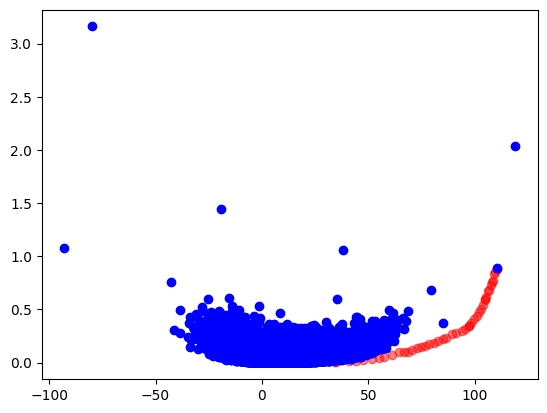

In [113]:
best_front_indices = fronts[0]
print("Number of solutions in first Pareto front:", len(best_front_indices))
print("Approximate Pareto front (variance, return):")
for idx in best_front_indices:
    w, (var, neg_ret) = final_pop[idx]
    non_zero = count_non_zero(w)
    print(f"Variance = {var:8.6f}, Return = {-neg_ret:8.4f} Non-zero: {non_zero}, Weights = {w}")
    plt.scatter(-neg_ret, var, color="red", alpha=0.5)
plt.scatter(random_profit, random_risk, color="blue", label="Random solutions")

In [117]:
final_pop = nsga2_markowitz(pop_size=75, generations=50, evaluate=evaluate3)
fronts = fast_non_dominated_sort(final_pop)

Number of solutions in first Pareto front: 75
Approximate Pareto front (variance, return, non_zero):
Variance = 0.089339, Return =  48.4943 Non-zero: 20, Weights = [0.03223534888551482, 0.010287796260431538, 0.016819066349389695, 0.05200441632900383, 0.0643397988959782, 0.019267766280654994, 0.0733618478671835, 0.01186974668652472, 0.011700685781877343, 0.03390611464778943, 0.028570264159641194, 0.2982061339932409, 0.06057058142182091, 0.03214705646849497, 0.031209707633423095, 0.017753917102213513, 0.03786226113670865, 0.015387341416526168, 0.12877896790551924, 0.0237211807780633]
Variance = 0.001258, Return =   8.6032 Non-zero: 19, Weights = [0.0803576117410229, 0.0439487080393213, 0.04963974739825882, 0.09175550053806945, 0.09598558330970952, 0.06665945431082715, 0.029606756796334028, 0.031007819876386403, 0.040251961132698105, 0.03531936689825327, 0.016698561703295402, 0.048944238619889904, 0.05864323969703369, 0.05843950475758661, 0.00860931031494816, 0.052404920530841594, 0.07709

Text(0.5, 0, 'Number of Non-zero Weights')

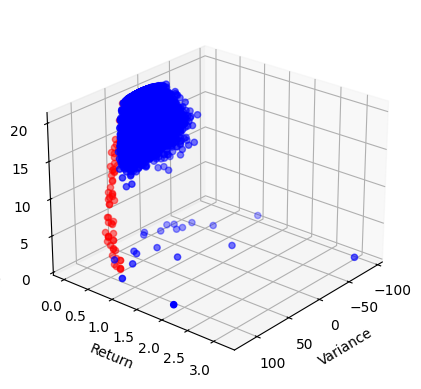

In [125]:
best_front_indices = fronts[0]
print("Number of solutions in first Pareto front:", len(best_front_indices))
print("Approximate Pareto front (variance, return, non_zero):")

fig = plt.figure(i)
ax = fig.add_subplot(111, projection='3d')

for idx in best_front_indices:
    w, (var, neg_ret, non_zero) = final_pop[idx]
    print(f"Variance = {var:8.6f}, Return = {-neg_ret:8.4f} Non-zero: {-non_zero}, Weights = {w}")
    ax.scatter(-neg_ret, var, -non_zero, color="red", alpha=0.5)

ax.scatter(random_profit, random_risk, random_nonzero, color="blue", label="Random solutions")
ax.view_init(elev=25, azim=40)

ax.set_xlabel("Variance")
ax.set_ylabel("Return")
ax.set_zlabel("Number of Non-zero Weights")

In [101]:
final_pop[0][1]

(np.float64(0.8599082456180084), np.float64(-109.31650695523682), 1)

In [109]:
# calculate 3d hypervolume of population
def hypervolume_3d(front):
    """
    Calculate the hypervolume of a 3D front.
    We assume the front is sorted in descending order.
    """
    volume = 0.0
    for i in range(len(front)-1):
        v1 = front[i][1]
        v2 = front[i+1][1]
        volume += (v2[0] - v1[0]) * (v2[1] - v1[1]) * (v2[2] - v1[2])
    return volume

In [ ]:
hypervolume_3d

np.float64(244.33623478675247)